# HR Attrition Predictor Notebook

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
import joblib

In [2]:
# Ensure required directories exist
os.makedirs('models', exist_ok=True)
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')


In [4]:
# Load the HR Analytics dataset
data_path = 'data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(data_path)
print(f"Dataset loaded with shape: {df.shape}")

Dataset loaded with shape: (14999, 10)


In [5]:
# Display first few rows of the dataset
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if len(missing_values[missing_values > 0]) > 0 else "No missing values found")


Missing Values:
No missing values found


## Data Preprocessing

In [7]:
# Make a copy of the dataframe
processed_df = df.copy()

In [8]:
# Drop irrelevant features
if 'EmployeeNumber' in processed_df.columns:
    processed_df.drop('EmployeeNumber', axis=1, inplace=True)

if 'Over18' in processed_df.columns and processed_df['Over18'].nunique() == 1:
    processed_df.drop('Over18', axis=1, inplace=True)

In [9]:
# Check for any constant columns and drop them
constant_cols = [col for col in processed_df.columns if processed_df[col].nunique() == 1]
if constant_cols:
    processed_df.drop(constant_cols, axis=1, inplace=True)
    print(f"Dropped constant columns: {constant_cols}")

In [10]:
# Encode categorical variables
categorical_cols = processed_df.select_dtypes(include=['object']).columns

In [11]:
# Create a dictionary to store the label encoders
label_encoders = {}

for col in categorical_cols:
    if col != 'left':  # We'll handle left separately
        le = LabelEncoder()
        processed_df[col] = le.fit_transform(processed_df[col])
        label_encoders[col] = le

In [12]:
# Convert left to binary (1 for 'Yes', 0 for 'No')
if 'left' in processed_df.columns:
    processed_df['left'] = processed_df['left'].map({1: 1, 0: 0})  # Already binary

In [13]:
# Scale numerical features
numerical_cols = processed_df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

In [14]:
# Create a new dataframe for the scaled features
scaled_features = pd.DataFrame(
    scaler.fit_transform(processed_df[numerical_cols]),
    columns=numerical_cols,
    index=processed_df.index
)

In [15]:
# Replace the original numerical columns with the scaled ones
for col in numerical_cols:
    if col != 'left':  # Don't scale the target variable
        processed_df[col] = scaled_features[col]

print("Data preprocessing completed!")

Data preprocessing completed!


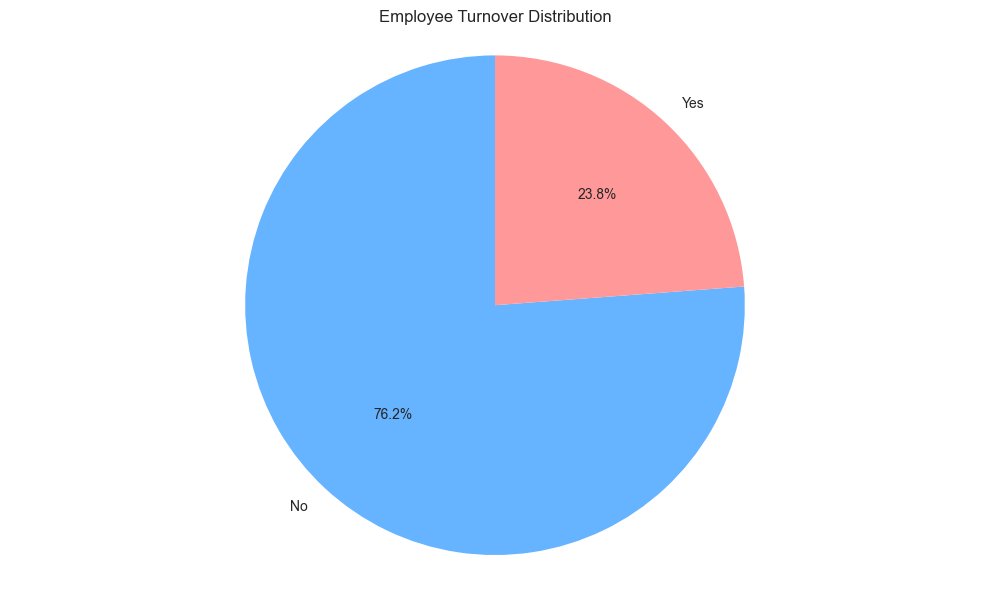

In [16]:
# EDA - Plot the distribution of attrition (pie chart)
plt.figure(figsize=(10, 6))
left_counts = df['left'].value_counts()
labels = ['No', 'Yes']
plt.pie(left_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Employee Turnover Distribution')
plt.axis('equal')
plt.tight_layout()
plt.savefig('images/attrition_distribution_pie.png')
plt.show()

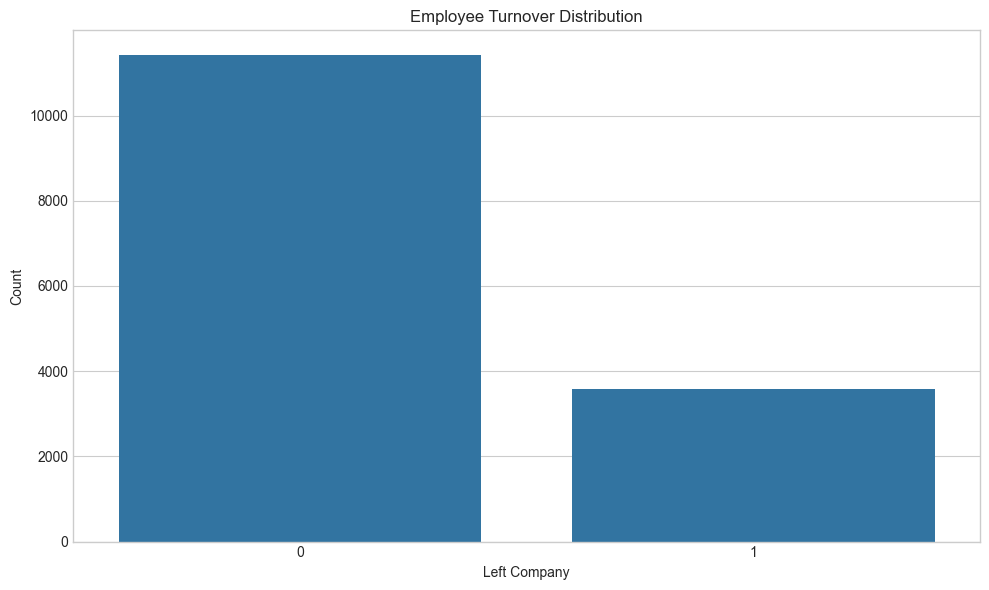

In [17]:
# EDA - Plot the distribution of attrition (bar plot)
plt.figure(figsize=(10, 6))
sns.countplot(x='left', data=df)
plt.title('Employee Turnover Distribution')
plt.xlabel('Left Company')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/attrition_distribution_bar.png')
plt.show()

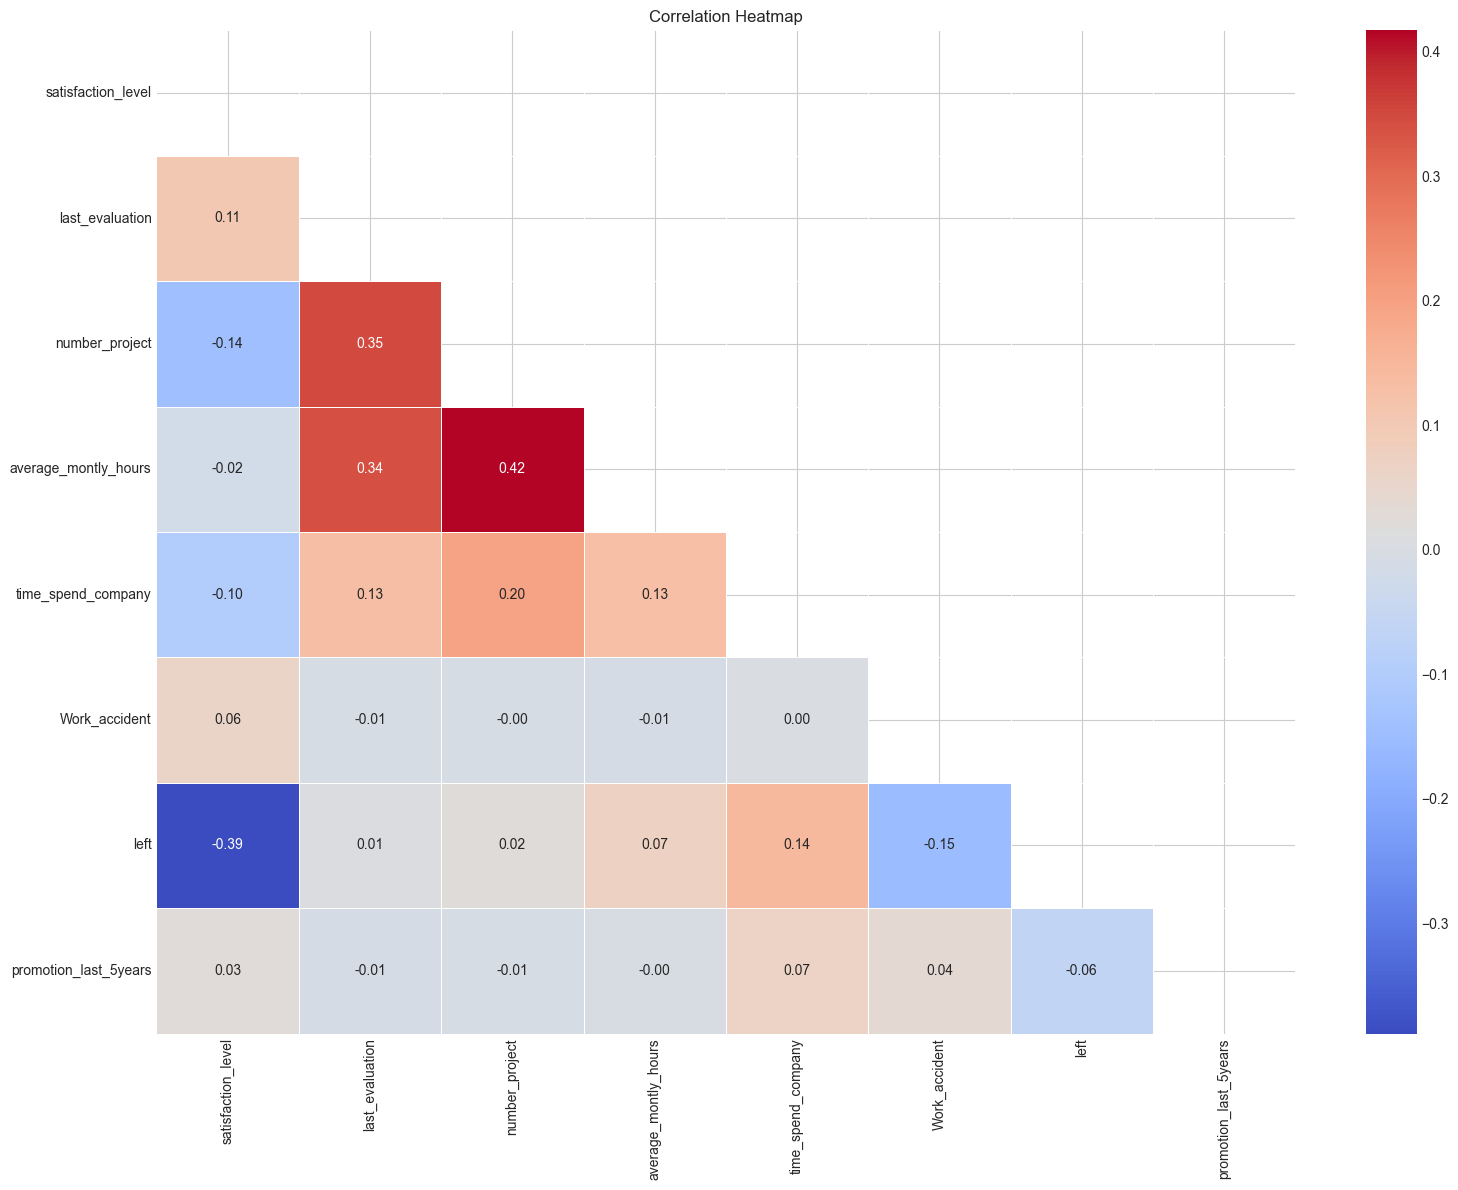

In [18]:
# EDA - Correlation heatmap
numerical_df = processed_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_df.corr()
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png')
plt.show()

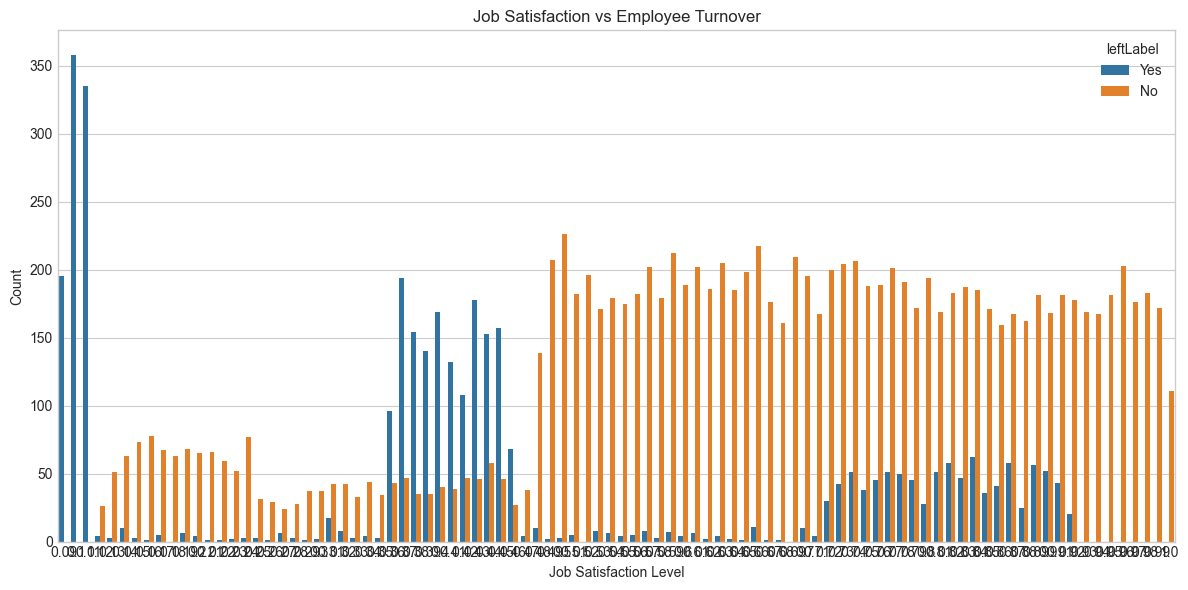

In [19]:
# EDA - Job Satisfaction vs Attrition
plot_df = df.copy()
if 'left' in plot_df.columns and plot_df['left'].dtype != 'object':
    plot_df['leftLabel'] = plot_df['left'].map({1: 'Yes', 0: 'No'})
    left_col = 'leftLabel'
else:
    left_col = 'left'

plt.figure(figsize=(12, 6))
sns.countplot(x='satisfaction_level', hue=left_col, data=plot_df)
plt.title('Job Satisfaction vs Employee Turnover')
plt.xlabel('Job Satisfaction Level')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/job_satisfaction_vs_attrition.png')
plt.show()

In [20]:
# Save preprocessed data
processed_df.to_csv('data/preprocessed_hr_data.csv', index=False)
print(f"Preprocessed data saved to data/preprocessed_hr_data.csv")

Preprocessed data saved to data/preprocessed_hr_data.csv


In [22]:
# Split data into train and test sets
X = processed_df.drop('left', axis=1)
y = processed_df['left']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (11999, 9), Test set shape: (3000, 9)


In [24]:
# Train a Decision Tree classifier with hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Base model
dt = DecisionTreeClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


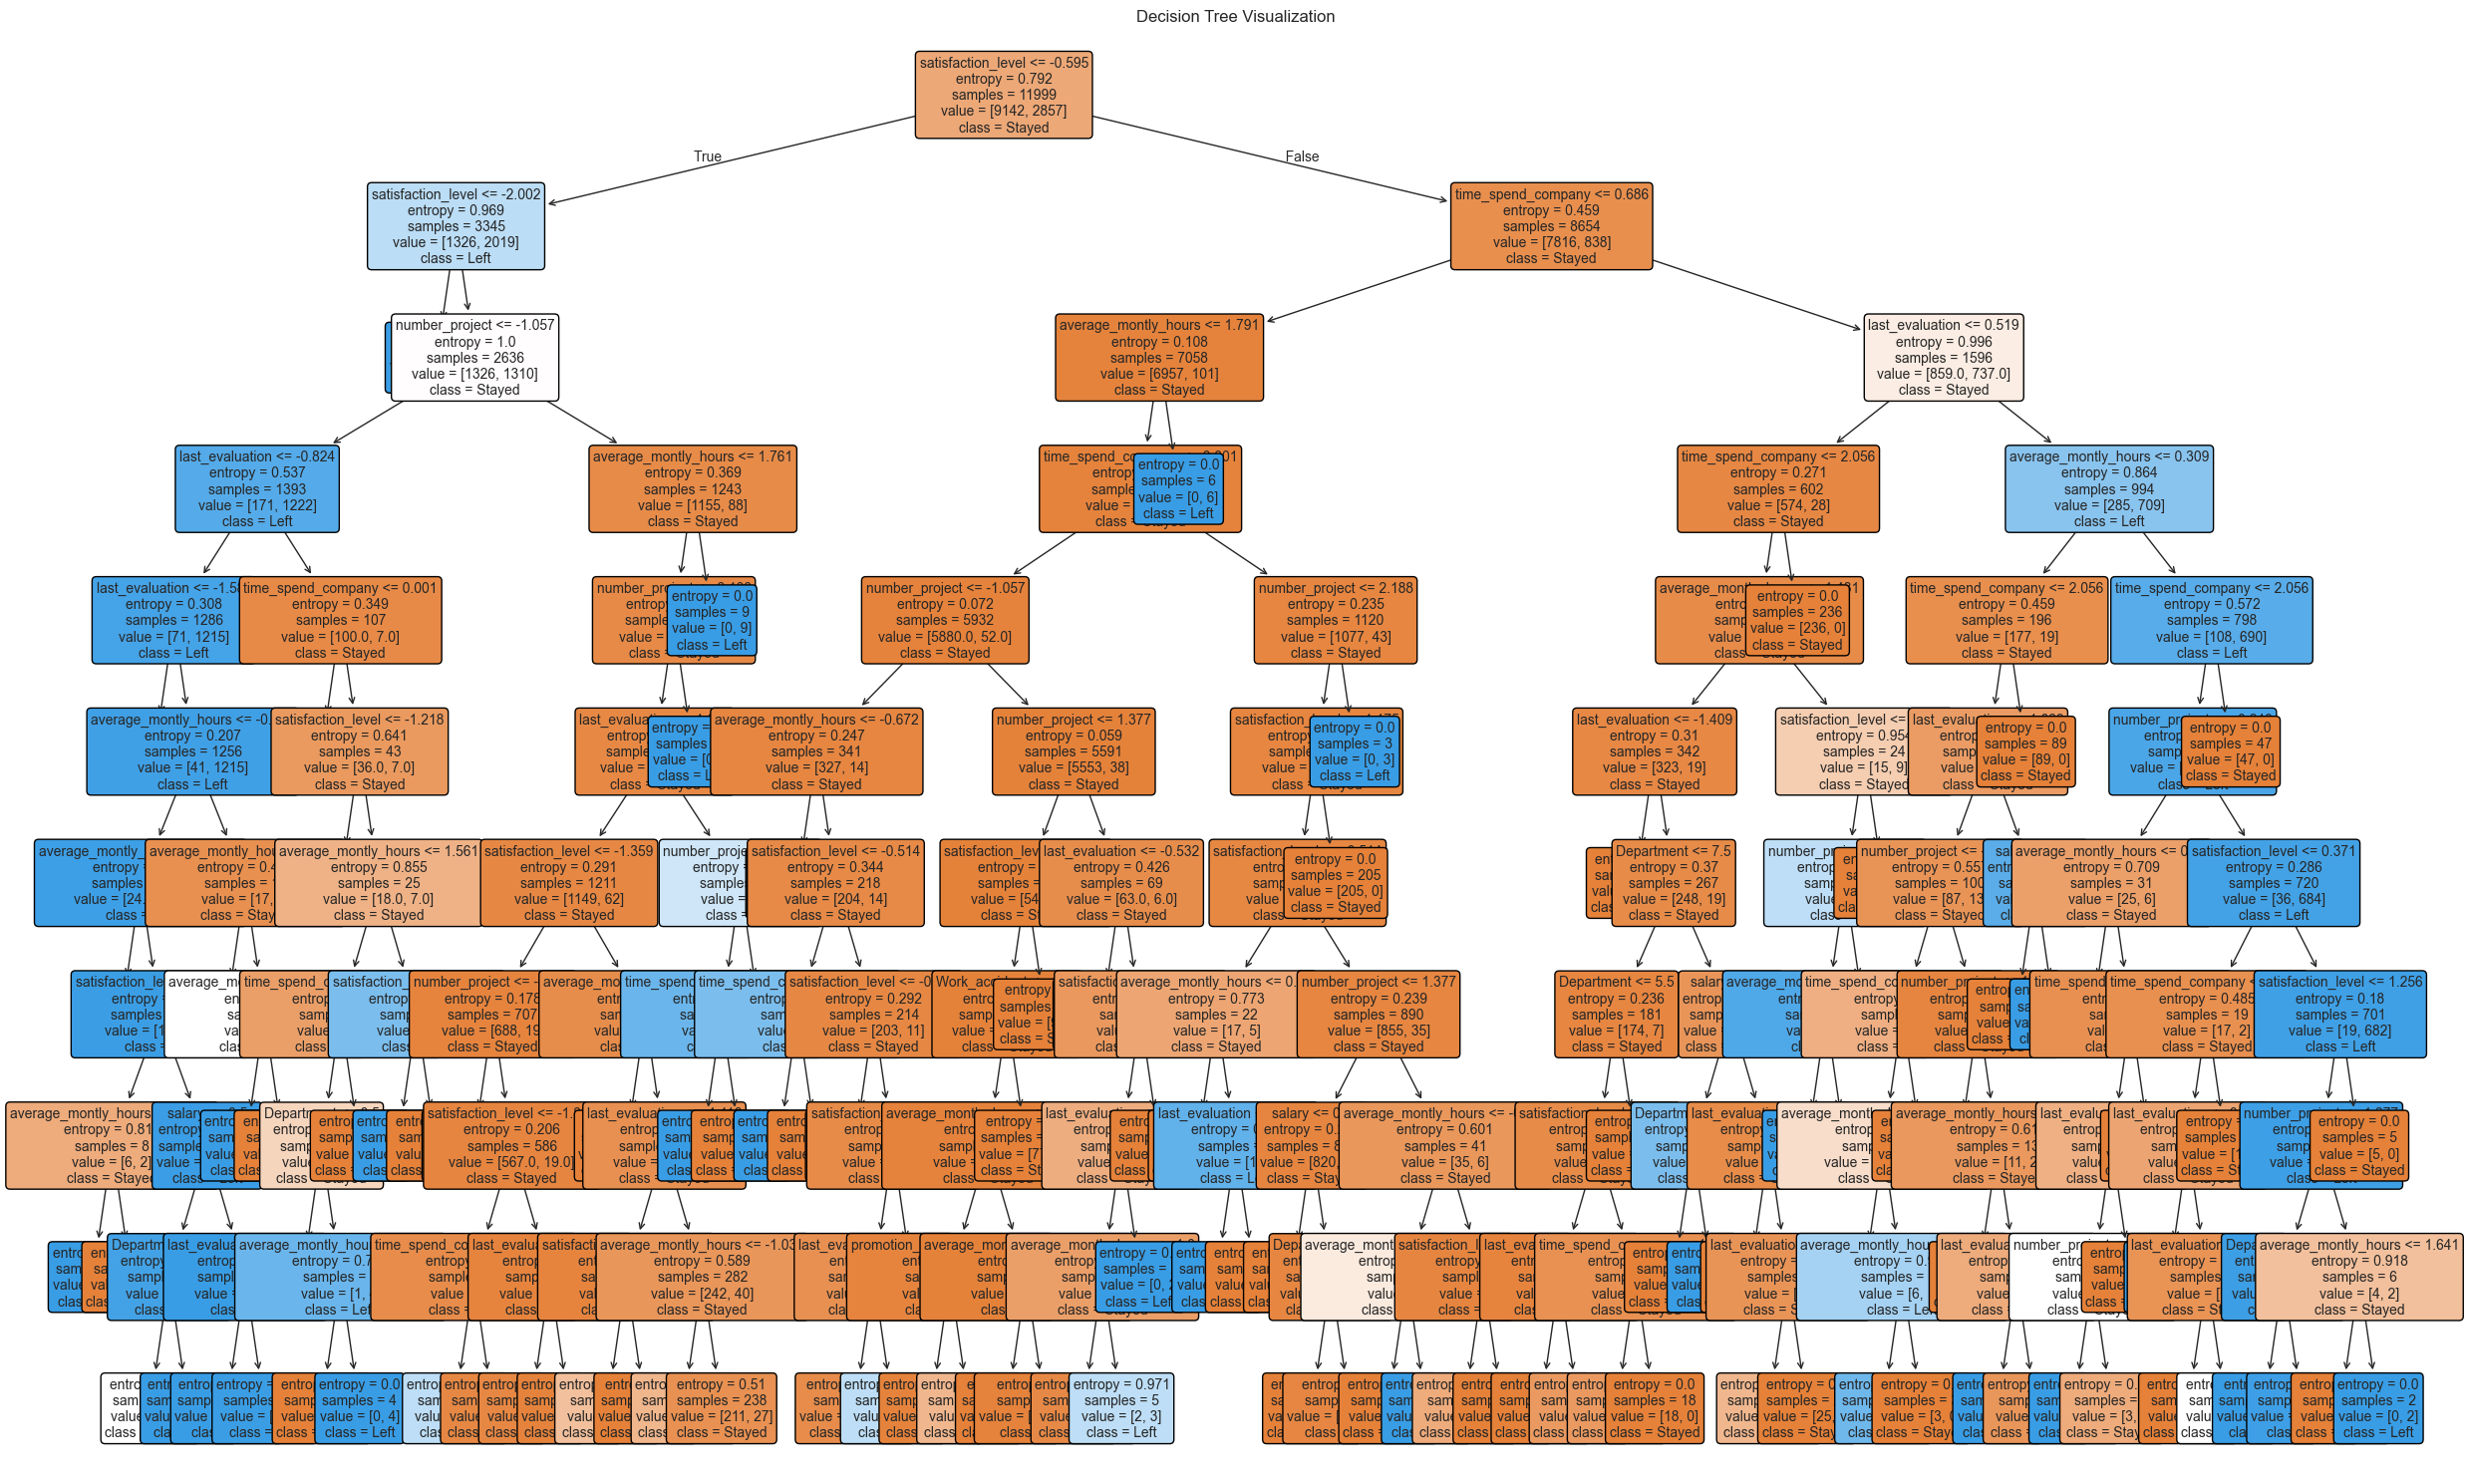

In [25]:
# Plot and save the decision tree
feature_names = X_train.columns.tolist()
plt.figure(figsize=(25, 15))
plot_tree(best_model, feature_names=feature_names, 
          class_names=['Stayed', 'Left'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.tight_layout()
plt.savefig('images/decision_tree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

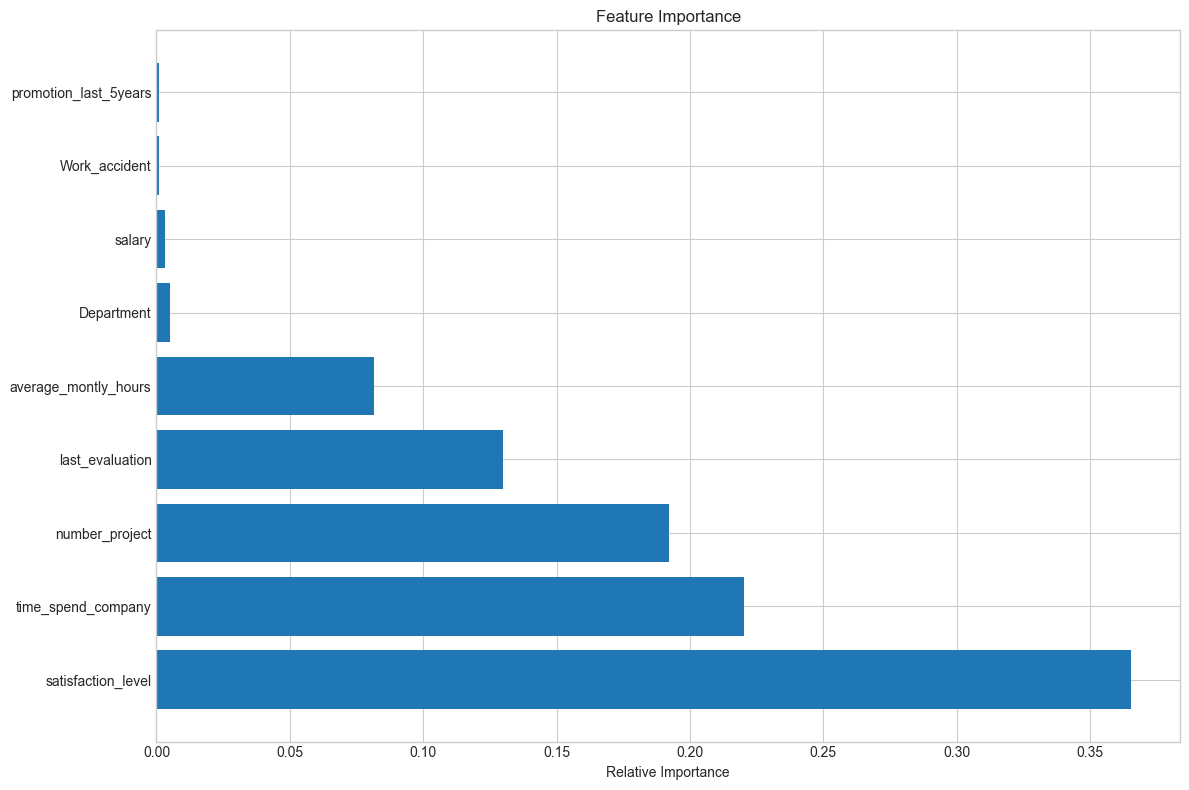

In [26]:
# Plot feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [feature_names[i] for i in indices]
indices = indices[:15]
names = names[:15]

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), names)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('images/feature_importance.png')
plt.show()

In [27]:
## Evaluate the model

In [28]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [29]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9797
Precision: 0.9725
Recall: 0.9412
F1 Score: 0.9566


In [30]:
# Save metrics to a file
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Create a dataframe and save to CSV
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('models/model_metrics.csv', index=False)

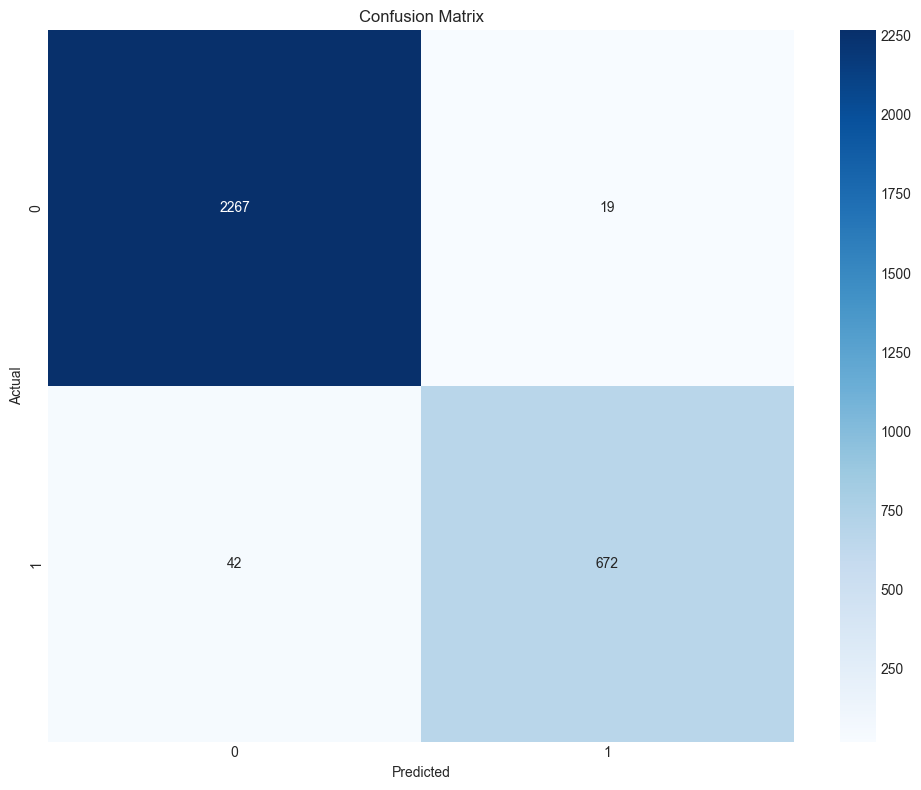

In [31]:
# Plot and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png')
plt.show()

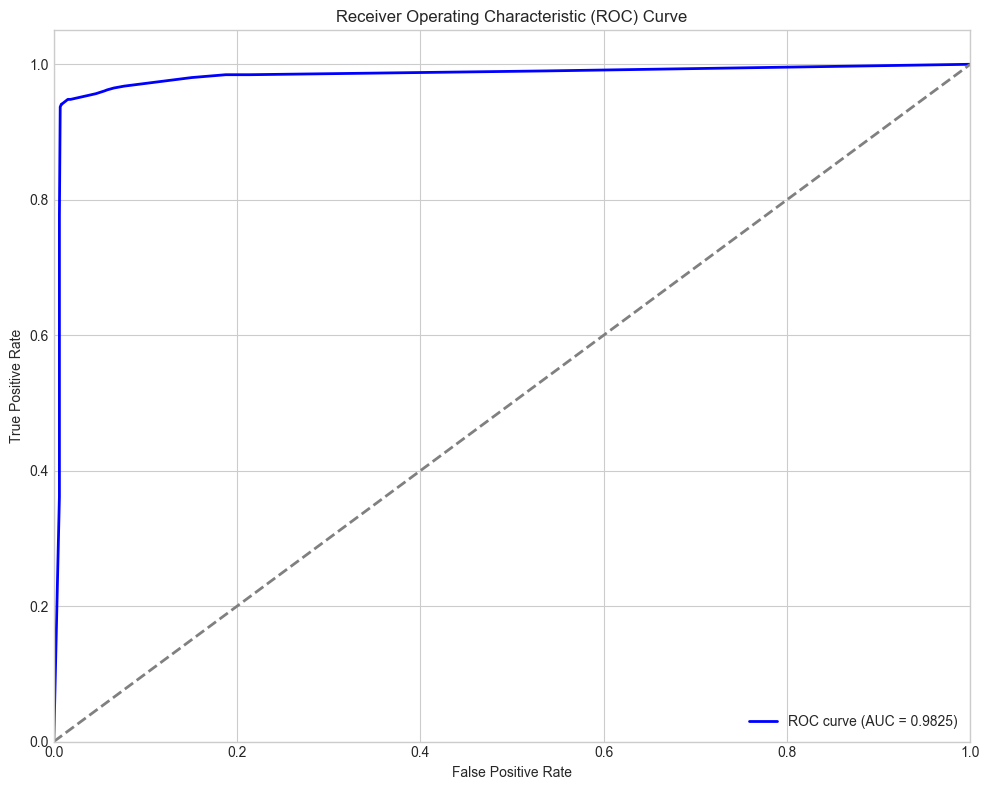

In [32]:
# Plot and save ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/roc_curve.png')
plt.show()

In [33]:
# Save detailed classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('models/classification_report.csv')

In [34]:
# Save model
joblib.dump(best_model, 'models/decision_tree_model.pkl')
print(f"Model saved to models/decision_tree_model.pkl")

Model saved to models/decision_tree_model.pkl


In [35]:
# Save test data for later use
X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

print("Model training and evaluation completed successfully!")

Model training and evaluation completed successfully!


## Begin Cluster Analysis

In [36]:
# Load original data for interpretable analysis
original_data_path = 'data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
original_data = pd.read_csv(original_data_path) if os.path.exists(original_data_path) else None

In [37]:
# Prepare data for clustering by dropping the target variable
if 'left' in X.columns:
    X_cluster = X.drop('left', axis=1)
else:
    X_cluster = X.copy()

In [38]:
# Find the optimal number of clusters using the Elbow method
inertia = []
max_k = 15
k_range = range(1, max_k + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

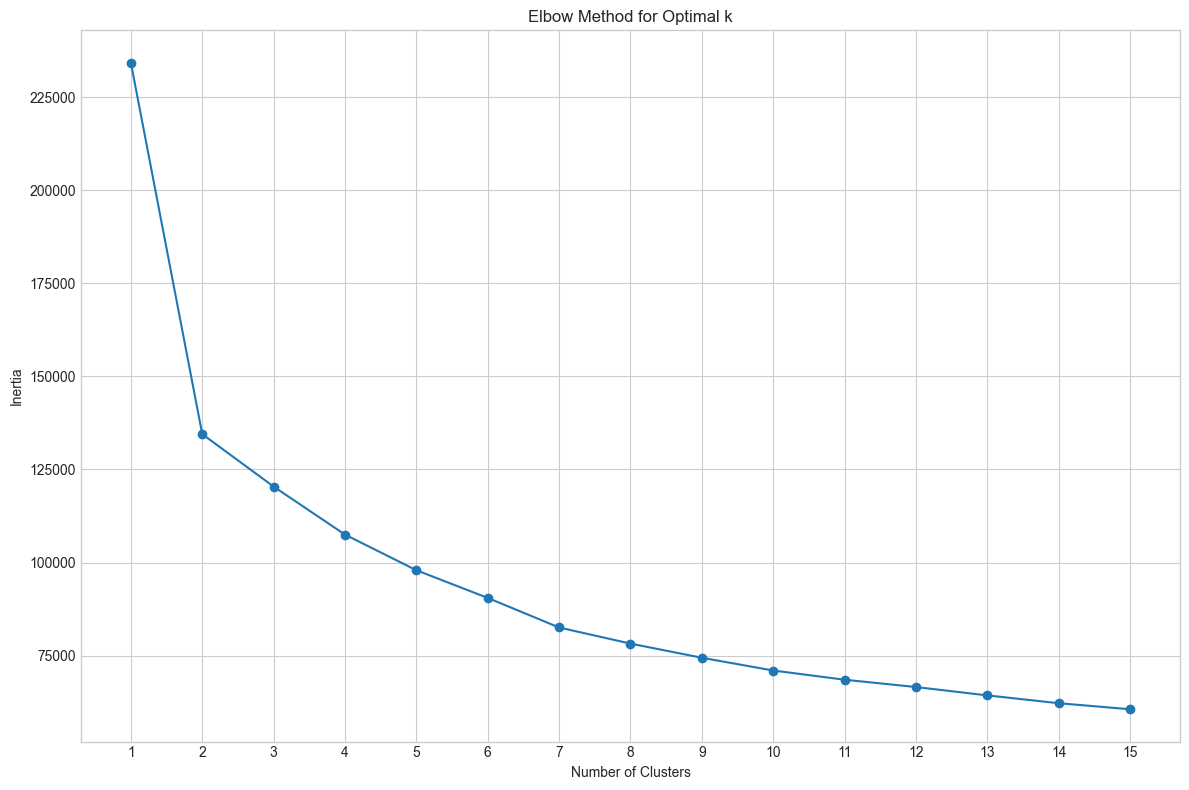

In [39]:
# Plot Elbow curve
plt.figure(figsize=(12, 8))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.savefig('images/kmeans_elbow.png')
plt.show()

In [40]:
# Determine optimal k (simple heuristic)
inertia_diff = np.diff(inertia)
inertia_diff2 = np.diff(inertia_diff)
optimal_k = np.argmax(inertia_diff2) + 2  # +2 due to two diff operations

In [42]:
# Ensure optimal_k is within range
optimal_k = min(max(optimal_k, 2), max_k)
print(f"Optimal number of clusters detected: {optimal_k}")

Optimal number of clusters detected: 2


In [43]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

In [44]:
# Add cluster labels to the data
data_with_clusters = X_cluster.copy()
data_with_clusters['Cluster'] = clusters

In [45]:
# Save the KMeans model
joblib.dump(kmeans, 'models/kmeans_model.pkl')

['models/kmeans_model.pkl']

In [46]:
# Save cluster data
data_with_clusters.to_csv('data/clustered_hr_data.csv', index=False)

## Visualize clusters using PCA

In [47]:
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_with_clusters.drop('Cluster', axis=1))

In [48]:
# Save PCA model for future use
joblib.dump(pca, 'models/pca_model.pkl')

['models/pca_model.pkl']

In [49]:
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data_with_clusters['Cluster']

In [50]:
# Save PCA results
pca_df.to_csv('data/pca_hr_results.csv', index=False)

c:\Users\TEST\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


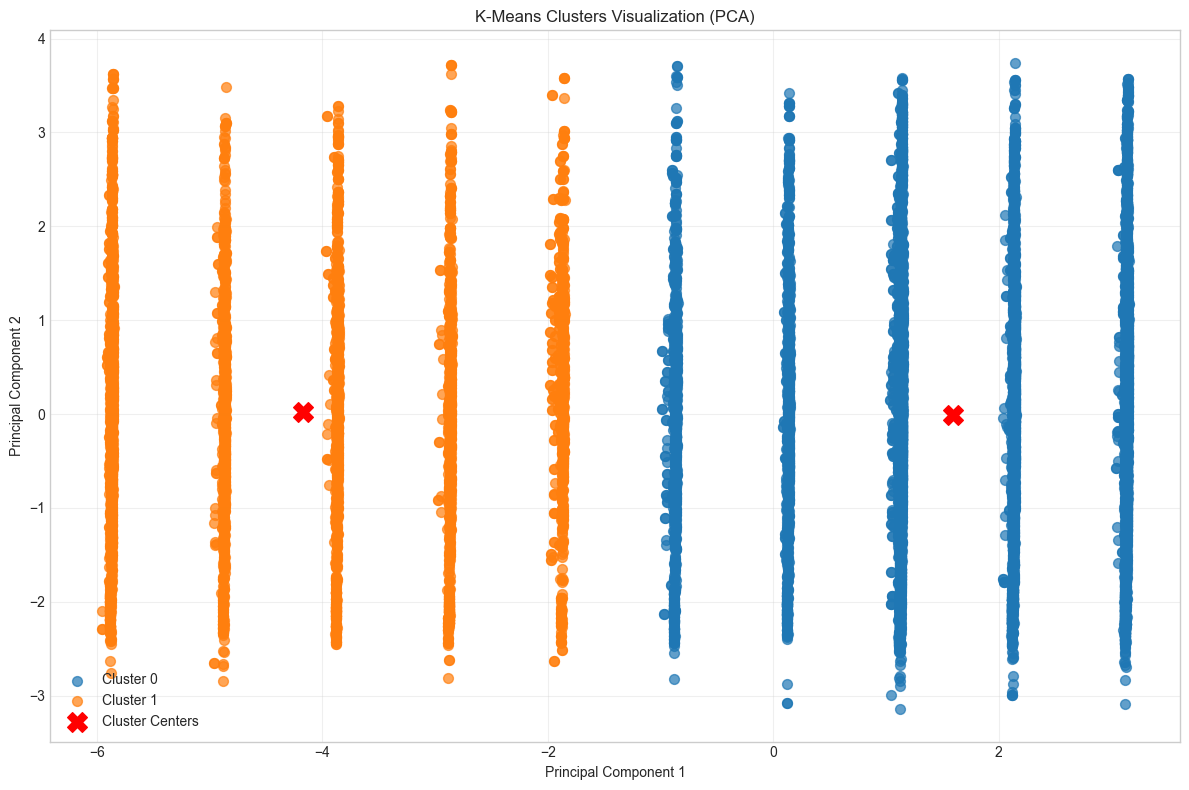

In [56]:
# Plot the clusters
plt.figure(figsize=(12, 8))

# Plot each cluster with a different color
for cluster_id in range(kmeans.n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'], 
        s=50, alpha=0.7,
        label=f'Cluster {cluster_id}'
    )

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_pca[:, 0], centers_pca[:, 1],
    s=200, marker='X', c='red', 
    label='Cluster Centers'
)

plt.title('K-Means Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/kmeans_clusters.png')
plt.show()

## Analyze cluster characteristics

In [57]:
# Get the number of clusters
n_clusters = data_with_clusters['Cluster'].nunique()

In [58]:
# Create a DataFrame to store cluster profiles
profiles = []

Cluster Profiles:


,Cluster,Size,Percentage,Mean_satisfaction_level,Mean_last_evaluation,Mean_number_project,Mean_average_montly_hours,Mean_time_spend_company,Mean_Work_accident,Mean_promotion_last_5years,Turnover_Rate
0,0,10849,72.331489,0.614356,0.716229,3.803023,201.078256,3.472302,0.145912,0.017605,24.582911
1,1,4150,27.668511,0.608853,0.715769,3.803133,200.977349,3.566024,0.141205,0.030843,21.783133


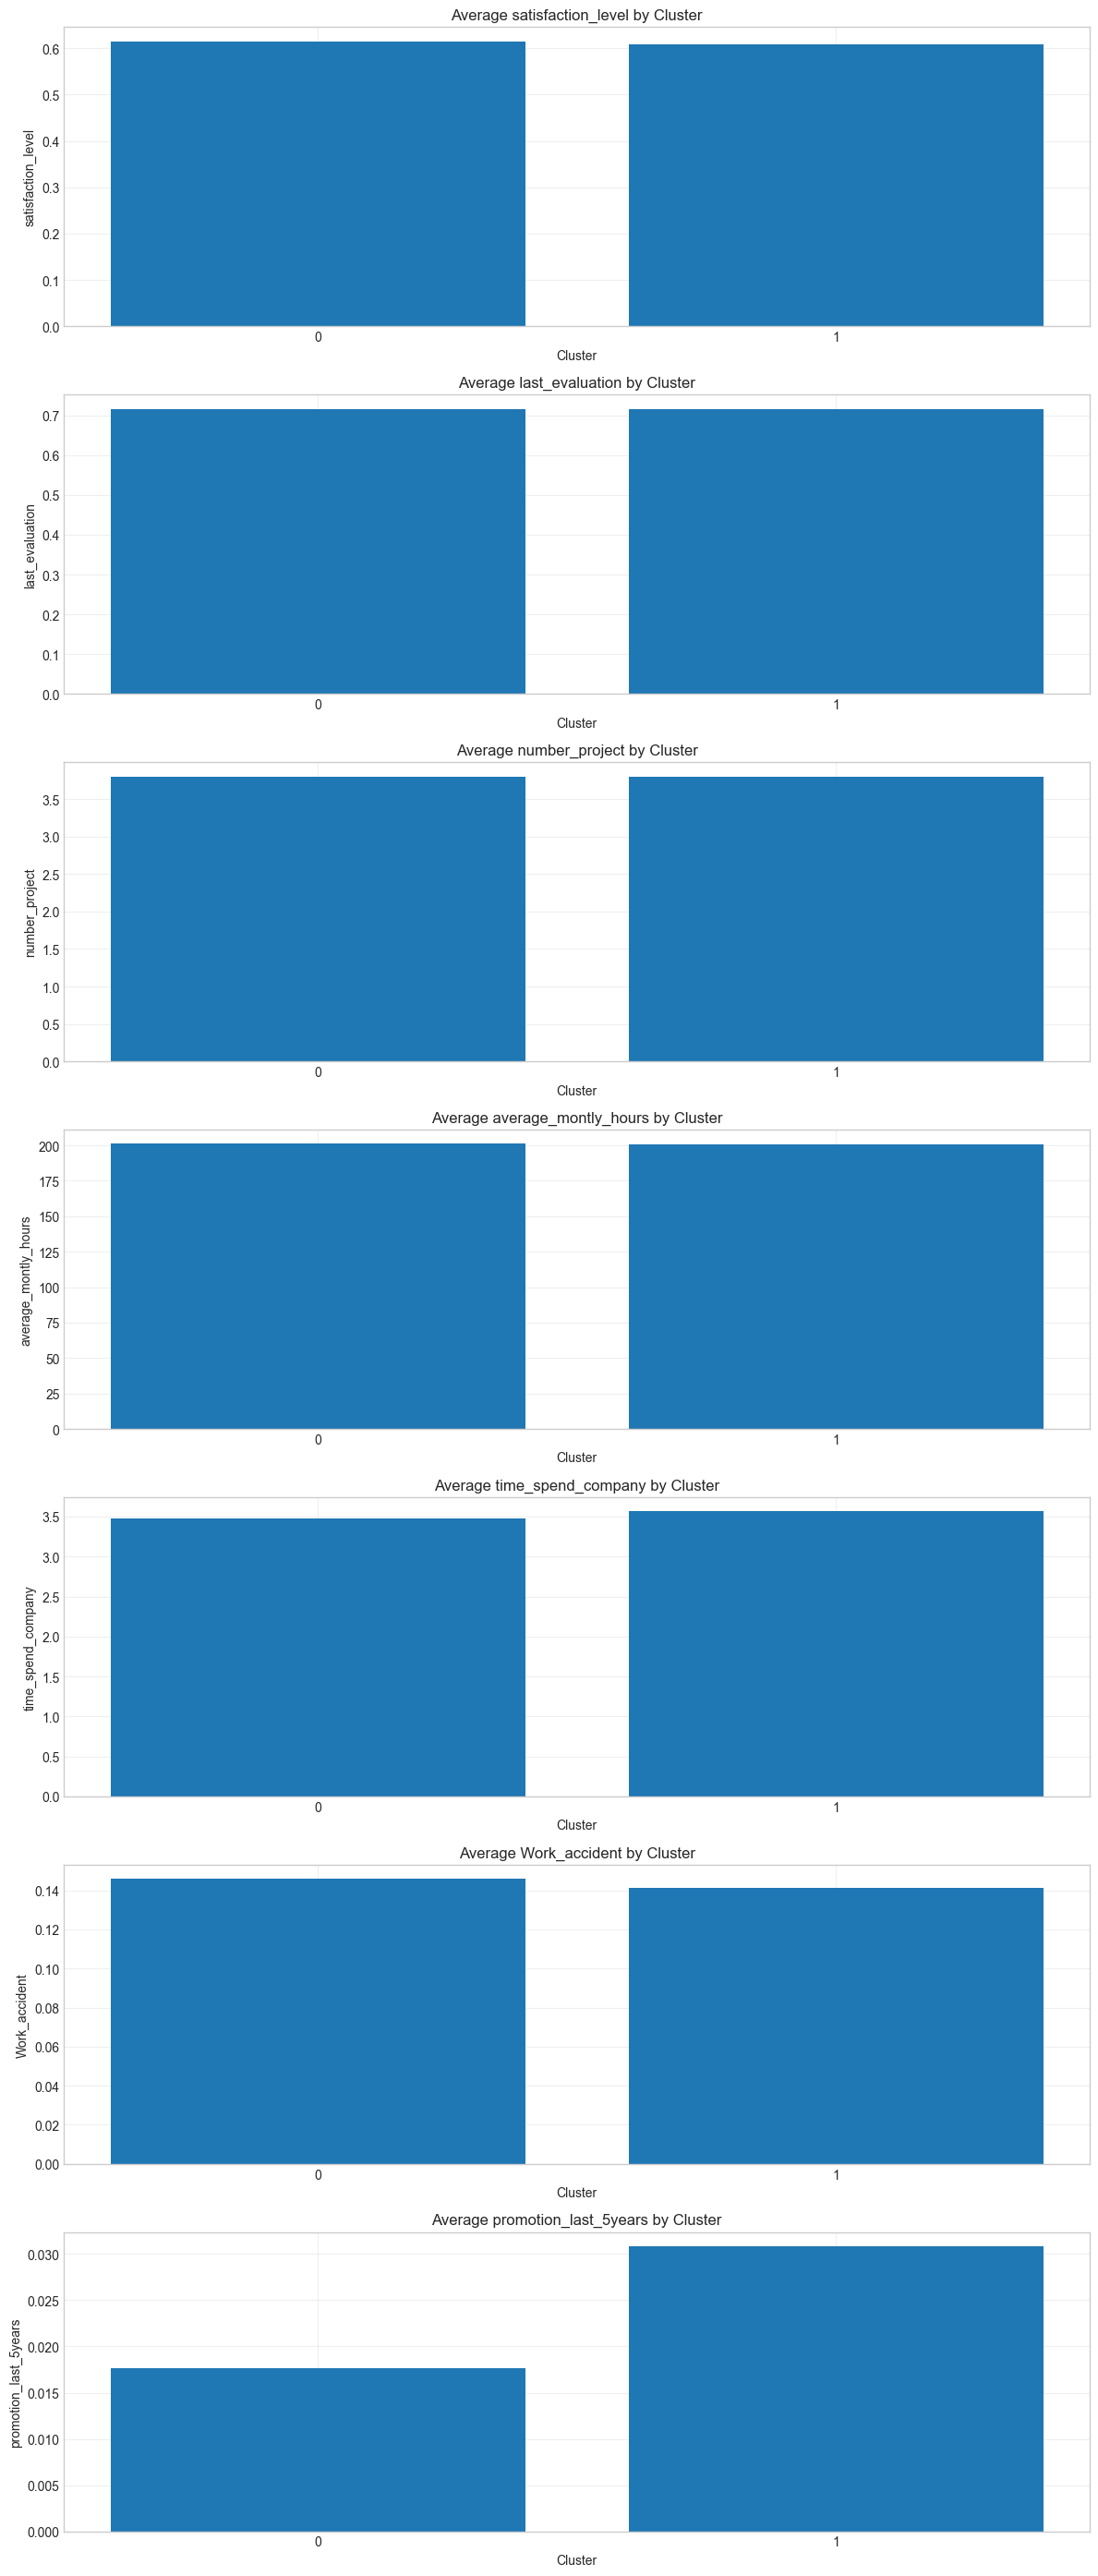

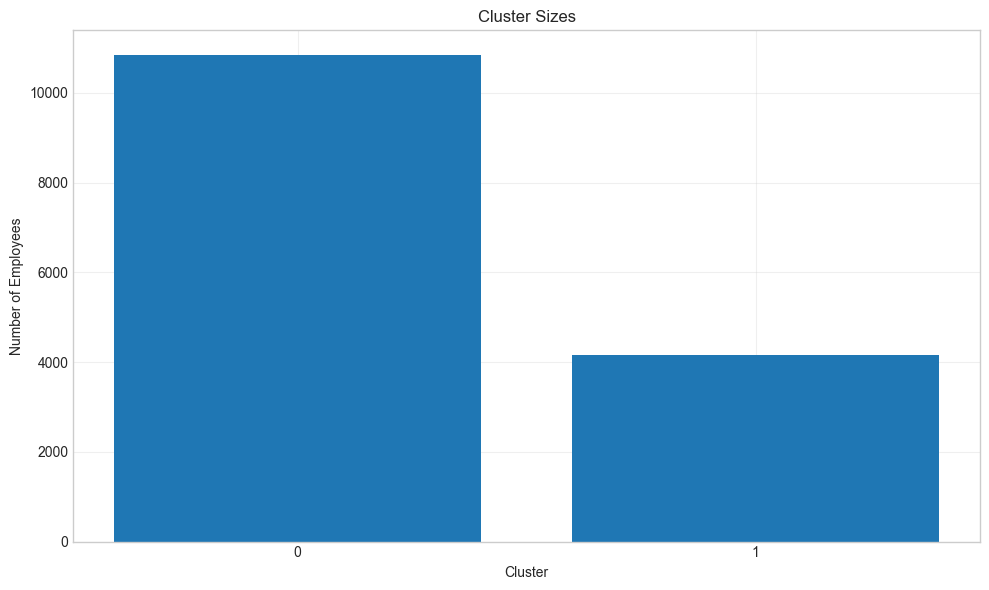

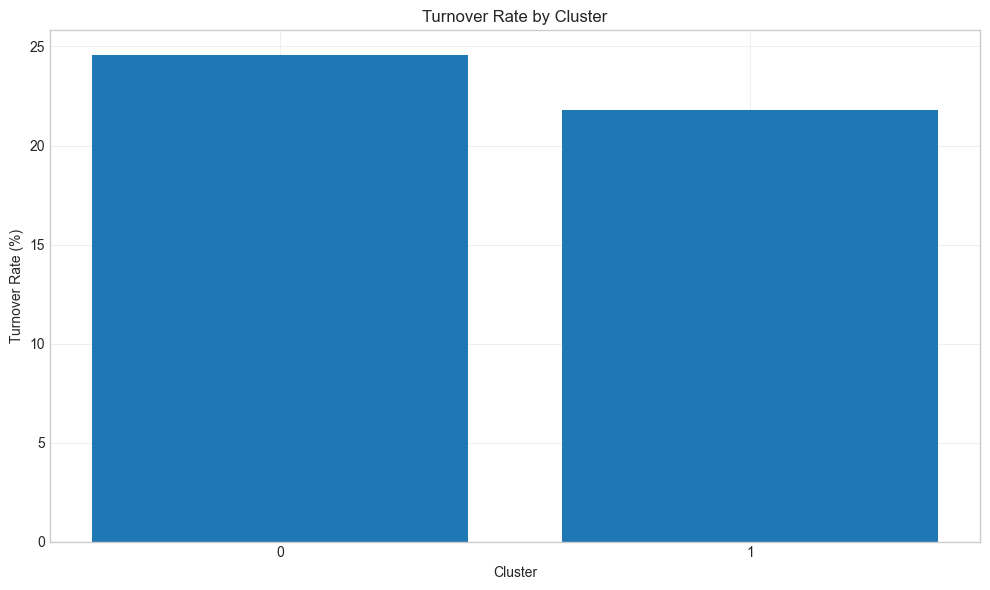

Clustering analysis completed successfully!
All analysis steps completed for HR Attrition Prediction!


In [59]:
# If we have the original data with non-scaled values, use it for more interpretable analysis
if original_data is not None:
    # Add cluster labels to original data
    original_data_with_clusters = original_data.copy()
    original_data_with_clusters['Cluster'] = data_with_clusters['Cluster'].values
    
    # For each cluster, compute mean values of important features
    for cluster_id in range(n_clusters):
        cluster_data = original_data_with_clusters[original_data_with_clusters['Cluster'] == cluster_id]
        
        # Select key features for profiling
        key_features = [
            'satisfaction_level', 'last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company', 'Work_accident',
            'promotion_last_5years'
        ]
        
        # Ensure all key features exist in the data
        key_features = [f for f in key_features if f in cluster_data.columns]
        
        # Compute profile
        profile = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Percentage': len(cluster_data) / len(original_data_with_clusters) * 100
        }
        
        # Add mean values for key features
        for feature in key_features:
            profile[f'Mean_{feature}'] = cluster_data[feature].mean()
        
        # Add turnover rate if available
        if 'left' in cluster_data.columns:
            turnover_values = cluster_data['left'].value_counts(normalize=True)
            profile['Turnover_Rate'] = turnover_values.get(1, 0) * 100  # Percentage
        
        profiles.append(profile)
    
    # Create profiles DataFrame and save it
    profiles_df = pd.DataFrame(profiles)
    profiles_df.to_csv('data/cluster_profiles.csv', index=False)
    
    # Display cluster profiles
    print("Cluster Profiles:")
    display(profiles_df)
    
    # Visualize key features for each cluster
    features_to_plot = [f'Mean_{feature}' for feature in key_features if f'Mean_{feature}' in profiles_df.columns]
    
    if features_to_plot:
        # Create subplots for each feature
        n_features = len(features_to_plot)
        fig, axes = plt.subplots(n_features, 1, figsize=(12, n_features * 4))
        
        # Handle case where there's only one feature
        if n_features == 1:
            axes = [axes]
        
        for i, feature in enumerate(features_to_plot):
            # Plot the feature for each cluster
            clean_feature_name = feature.replace('Mean_', '')
            cluster_ids = profiles_df['Cluster'].tolist()
            feature_values = profiles_df[feature].tolist()
            
            axes[i].bar(cluster_ids, feature_values)
            axes[i].set_title(f'Average {clean_feature_name} by Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(clean_feature_name)
            axes[i].set_xticks(cluster_ids)
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('images/cluster_profiles.png')
        plt.show()
        
        # Plot cluster sizes
        plt.figure(figsize=(10, 6))
        plt.bar(profiles_df['Cluster'], profiles_df['Size'])
        plt.title('Cluster Sizes')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Employees')
        plt.xticks(profiles_df['Cluster'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('images/cluster_sizes.png')
        plt.show()
        
        # Plot turnover rate by cluster if available
        if 'Turnover_Rate' in profiles_df.columns:
            plt.figure(figsize=(10, 6))
            plt.bar(profiles_df['Cluster'], profiles_df['Turnover_Rate'])
            plt.title('Turnover Rate by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel('Turnover Rate (%)')
            plt.xticks(profiles_df['Cluster'])
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('images/cluster_turnover_rates.png')
            plt.show()

print("Clustering analysis completed successfully!")
print("All analysis steps completed for HR Attrition Prediction!")